In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = trp
band = 3a
commitnumber = d5931a1
conc = None
dv = 0.001
klin = 0
molecule = h2o
ng_adju = [0, 0]
ng_refs = [2, 6]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(10, 250), (600, 250)]
tsfc = 300
vmax = 620
vmin = 540
w_diffuse = [(1.9, 1.7), (1.4, 1.4, 1.4, 1.55, 1.6, 1.66)]
wgt = [(0.7, 0.7), (0.7, 0.5, 0.5, 0.5, 0.5, 0.5)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

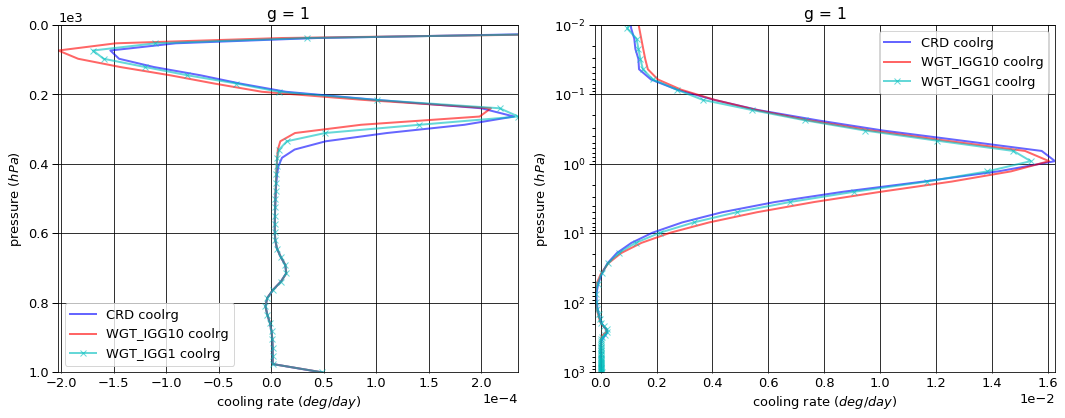

# Figure: cooling rate g-group 2

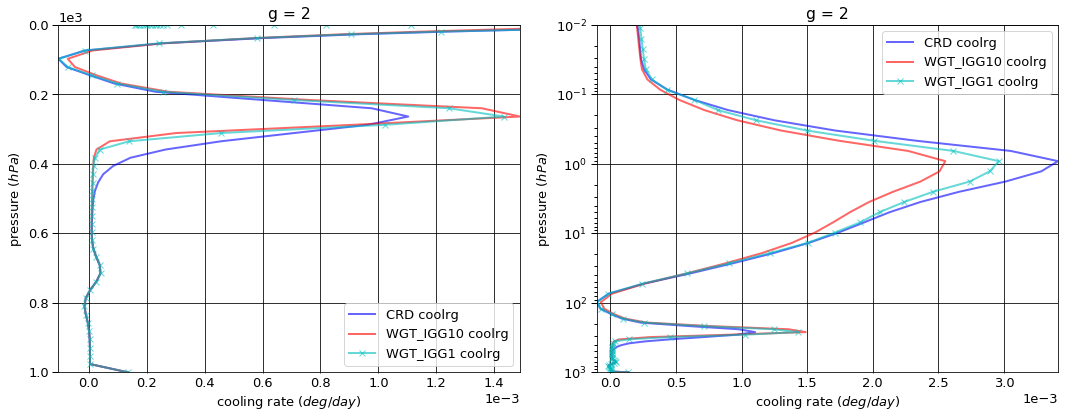

# Figure: cooling rate g-group 3

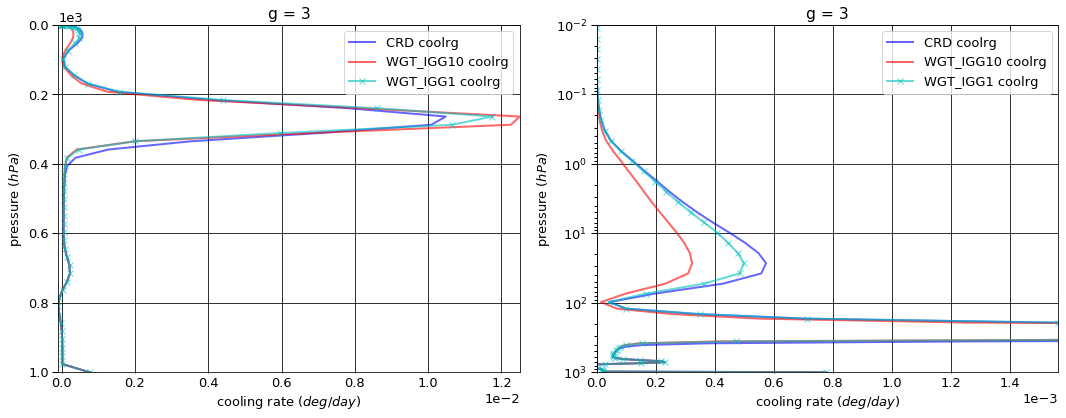

# Figure: cooling rate g-group 4

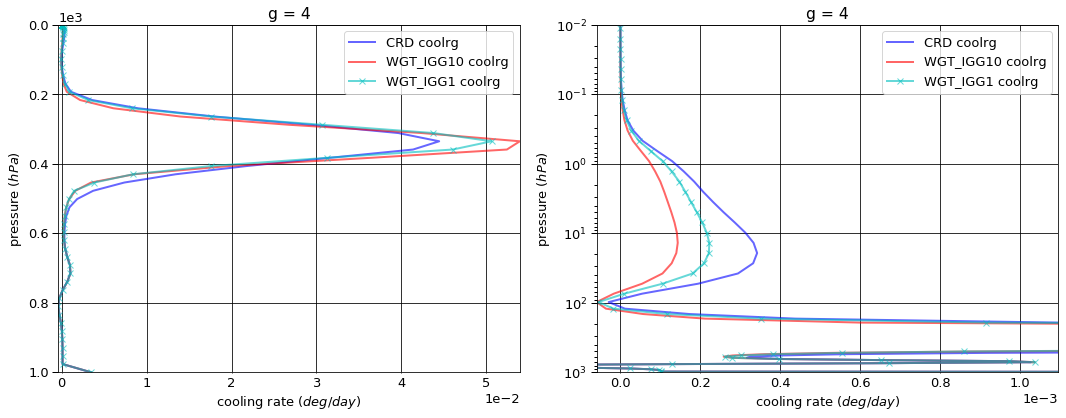

# Figure: cooling rate g-group 5

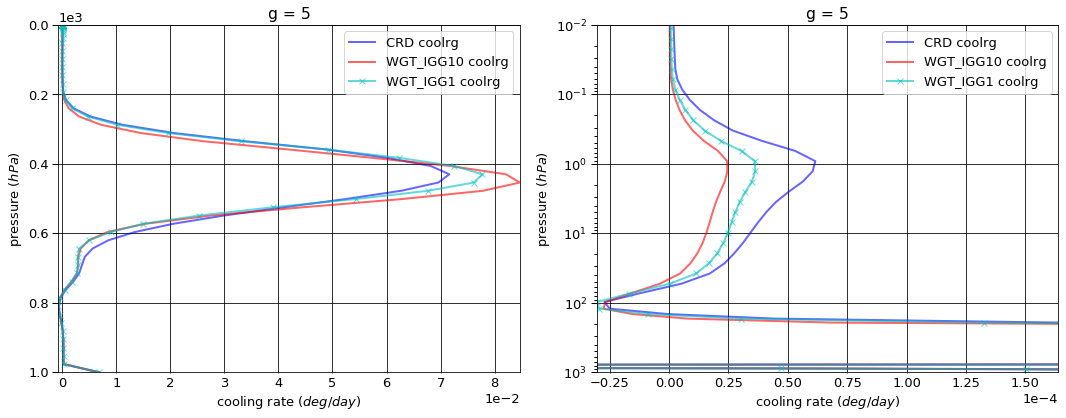

# Figure: cooling rate g-group 6

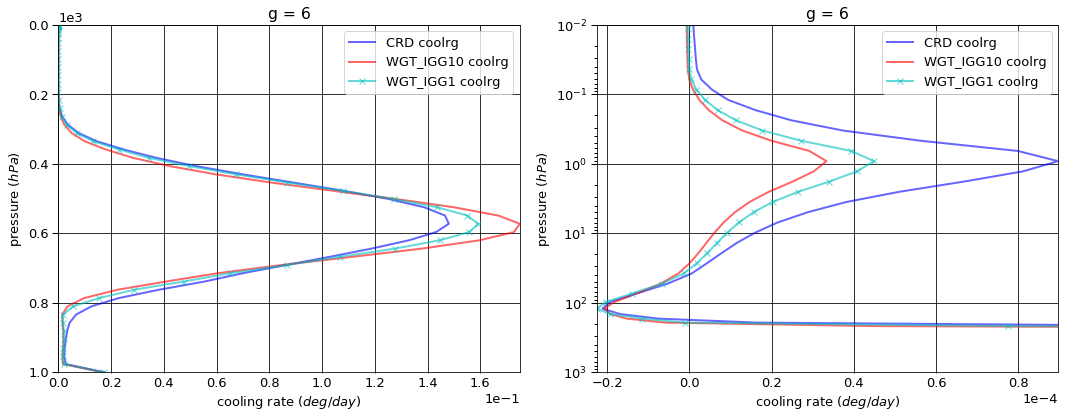

# Figure: cooling rate g-group 7

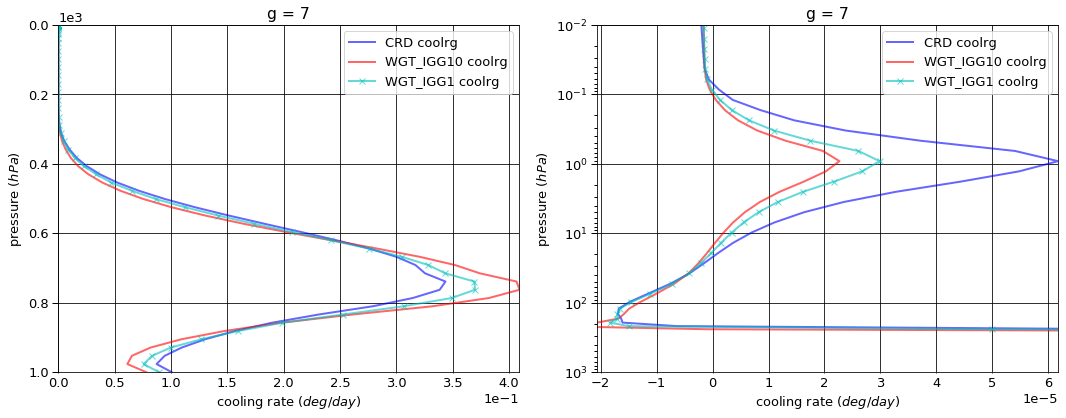

# Figure: cooling rate g-group 8

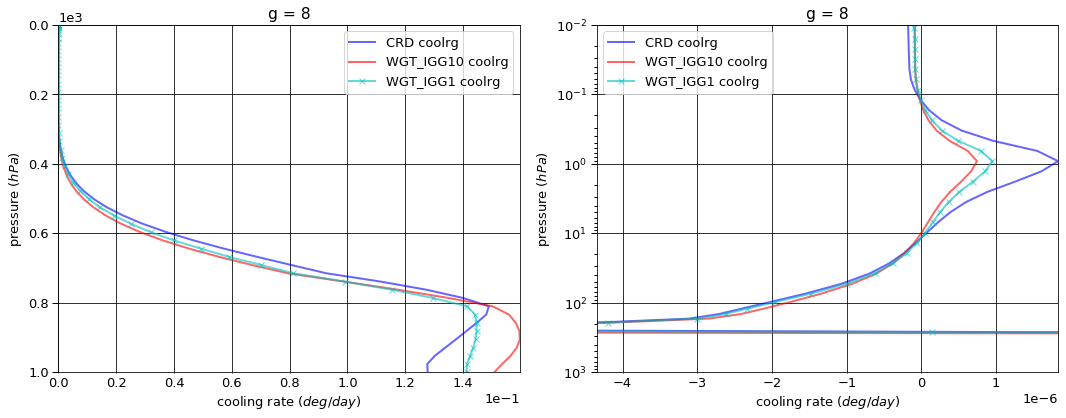

# Figure: cooling rate g-group total

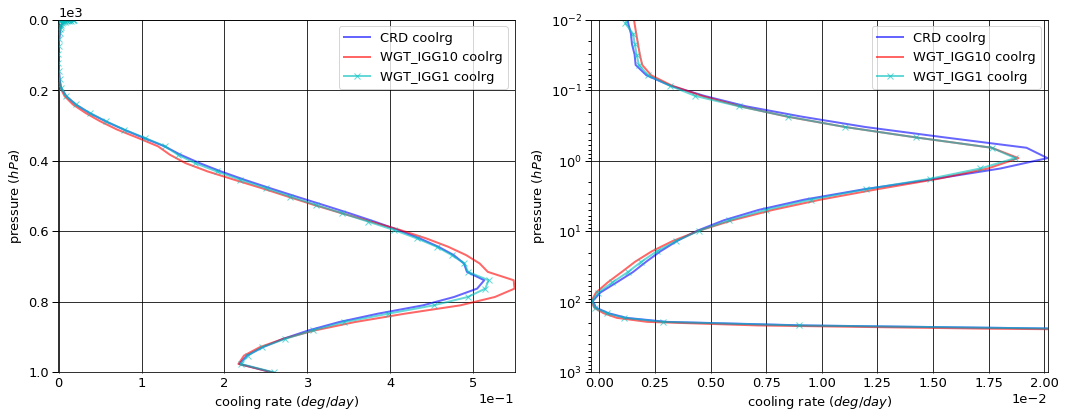

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.010076   0.000000  -0.010076
  1013.0   76     -0.021652   0.021519  -0.000133
2 0.0      1      -0.024017   0.000000  -0.024017
  1013.0   76     -0.060607   0.060236  -0.000372
3 0.0      1      -0.146262   0.000000  -0.146262
  1013.0   76     -0.347853   0.345723  -0.002130
4 0.0      1      -0.788802   0.000000  -0.788802
  1013.0   76     -1.558226   1.548671  -0.009554
5 0.0      1      -1.837278   0.000000  -1.837278
  1013.0   76     -3.049055   3.030381  -0.018675
6 0.0      1      -5.099170   0.000000  -5.099170
  1013.0   76     -7.199451   7.148500  -0.050952
7 0.0      1     -14.175392   0.000000 -14.175392
  1013.0   76    -17.414039  16.831305  -0.582734
8 0.0      1      -7.926689   0.000000  -7.926689
  1013.0   76     -8.840851   6.848357  -1.992494


WGT_IGG10


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.010046   0.000000  -0.010046
  1013.0   76     -0.021742   0.021608  -0.000134
2 0.0      1      -0.022651   0.000000  -0.022651
  1013.0   76     -0.060882   0.060505  -0.000376
3 0.0      1      -0.146274   0.000000  -0.146274
  1013.0   76     -0.349794   0.347632  -0.002162
4 0.0      1      -0.791938   0.000000  -0.791938
  1013.0   76     -1.565710   1.556033  -0.009677
5 0.0      1      -1.853050   0.000000  -1.853050
  1013.0   76     -3.066533   3.047580  -0.018953
6 0.0      1      -5.124164   0.000000  -5.124164
  1013.0   76     -7.241924   7.194707  -0.047217
7 0.0      1     -14.244234   0.000000 -14.244234
  1013.0   76    -17.456576  17.116391  -0.340186
8 0.0      1      -7.912294   0.000000  -7.912294
  1013.0   76     -8.728573   6.846702  -1.881871


WGT_IGG1


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.009939   0.000000  -0.009939
  1013.0   76     -0.021742   0.021608  -0.000134
2 0.0      1      -0.023057   0.000000  -0.023057
  1013.0   76     -0.060882   0.060505  -0.000376
3 0.0      1      -0.143565   0.000000  -0.143565
  1013.0   76     -0.349794   0.347632  -0.002162
4 0.0      1      -0.780782   0.000000  -0.780782
  1013.0   76     -1.565710   1.556033  -0.009677
5 0.0      1      -1.827602   0.000000  -1.827602
  1013.0   76     -3.066533   3.047580  -0.018953
6 0.0      1      -5.098919   0.000000  -5.098919
  1013.0   76     -7.241924   7.193347  -0.048578
7 0.0      1     -14.209650   0.000000 -14.209650
  1013.0   76    -17.456576  17.033902  -0.422675
8 0.0      1      -7.903044   0.000000  -7.903044
  1013.0   76     -8.728573   6.610468  -2.118104


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000031  0.000000  0.000031
  1013.0   76    -0.000090  0.000089 -0.000001
2 0.0      1      0.001365  0.000000  0.001365
  1013.0   76    -0.000274  0.000270 -0.000004
3 0.0      1     -0.000011  0.000000 -0.000011
  1013.0   76    -0.001942  0.001910 -0.000032
4 0.0      1     -0.003137  0.000000 -0.003137
  1013.0   76    -0.007484  0.007362 -0.000123
5 0.0      1     -0.015772  0.000000 -0.015772
  1013.0   76    -0.017478  0.017200 -0.000278
6 0.0      1     -0.024994  0.000000 -0.024994
  1013.0   76    -0.042473  0.046207  0.003735
7 0.0      1     -0.068842  0.000000 -0.068842
  1013.0   76    -0.042537  0.285086  0.242548
8 0.0      1      0.014395  0.000000  0.014395
  1013.0   76     0.112278 -0.001655  0.110624


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000137  0.000000  0.000137
  1013.0   76    -0.000090  0.000089 -0.000001
2 0.0      1      0.000960  0.000000  0.000960
  1013.0   76    -0.000274  0.000270 -0.000004
3 0.0      1      0.002697  0.000000  0.002697
  1013.0   76    -0.001942  0.001910 -0.000032
4 0.0      1      0.008019  0.000000  0.008019
  1013.0   76    -0.007484  0.007362 -0.000123
5 0.0      1      0.009676  0.000000  0.009676
  1013.0   76    -0.017478  0.017200 -0.000278
6 0.0      1      0.000251  0.000000  0.000251
  1013.0   76    -0.042473  0.044847  0.002374
7 0.0      1     -0.034258  0.000000 -0.034258
  1013.0   76    -0.042537  0.202597  0.160059
8 0.0      1      0.023645  0.000000  0.023645
  1013.0   76     0.112278 -0.237888 -0.125610

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1      5.547039e-04
  1001.112500 75     4.778636e-05
2 0.000312    1      1.245661e-04
  1001.112500 75     1.336934e-04
3 0.000312    1      4.022356e-09
  1001.112500 75     7.659643e-04
4 0.000312    1      3.077839e-07
  1001.112500 75     3.435615e-03
5 0.000312    1      7.832917e-07
  1001.112500 75     6.716025e-03
6 0.000312    1     -3.024973e-07
  1001.112500 75     1.741268e-02
7 0.000312    1     -2.857268e-06
  1001.112500 75     1.008396e-01
8 0.000312    1     -2.055796e-07
  1001.112500 75     1.277727e-01


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      8.572677e-04
  1001.112500 75     4.831446e-05
2 0.000312    1      1.456364e-04
  1001.112500 75     1.352889e-04
3 0.000312    1      2.131447e-09
  1001.112500 75     7.773003e-04
4 0.000312    1      1.495600e-07
  1001.112500 75     3.479264e-03
5 0.000312    1     -1.317534e-07
  1001.112500 75     6.814343e-03
6 0.000312    1     -1.080349e-06
  1001.112500 75     1.687829e-02
7 0.000312    1     -1.885088e-06
  1001.112500 75     7.825203e-02
8 0.000312    1     -1.003281e-07
  1001.112500 75     1.508138e-01


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      6.918108e-04
  1001.112500 75     4.831446e-05
2 0.000312    1      1.602600e-04
  1001.112500 75     1.352889e-04
3 0.000312    1      3.573926e-09
  1001.112500 75     7.773003e-04
4 0.000312    1      2.940301e-07
  1001.112500 75     3.479264e-03
5 0.000312    1      1.097725e-07
  1001.112500 75     6.814338e-03
6 0.000312    1     -9.988381e-07
  1001.112500 75     1.716663e-02
7 0.000312    1     -1.981777e-06
  1001.112500 75     8.954778e-02
8 0.000312    1     -1.078212e-07
  1001.112500 75     1.412378e-01


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      3.025638e-04
  1001.112500 75     5.281070e-07
2 0.000312    1      2.107030e-05
  1001.112500 75     1.595550e-06
3 0.000312    1     -1.890909e-09
  1001.112500 75     1.133604e-05
4 0.000312    1     -1.582239e-07
  1001.112500 75     4.364960e-05
5 0.000312    1     -9.150452e-07
  1001.112500 75     9.831770e-05
6 0.000312    1     -7.778520e-07
  1001.112500 75    -5.343940e-04
7 0.000312    1      9.721799e-07
  1001.112500 75    -2.258754e-02
8 0.000312    1      1.052515e-07
  1001.112500 75     2.304103e-02


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.371069e-04
  1001.112500 75     5.281070e-07
2 0.000312    1      3.569396e-05
  1001.112500 75     1.595550e-06
3 0.000312    1     -4.484295e-10
  1001.112500 75     1.133604e-05
4 0.000312    1     -1.375384e-08
  1001.112500 75     4.364960e-05
5 0.000312    1     -6.735192e-07
  1001.112500 75     9.831320e-05
6 0.000312    1     -6.963407e-07
  1001.112500 75    -2.460490e-04
7 0.000312    1      8.754903e-07
  1001.112500 75    -1.129179e-02
8 0.000312    1      9.775837e-08
  1001.112500 75     1.346508e-02

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.007687,0.00000,-30.007687
1013.0,76,-38.491734,35.83469,-2.657044



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.104651,0.000000,-30.104651
1013.0,76,-38.491734,36.191159,-2.300576



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.996558,0.000000,-29.996558
1013.0,76,-38.491734,35.871076,-2.620659



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-9.696487e-02,0.000000,-0.096965
1013.0,76,2.500000e-07,0.356469,0.356468



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.112841e-02,0.000000,0.011128
1013.0,76,2.500000e-07,0.036386,0.036385


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.000677
1001.112500,75,0.257124



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.001000
1001.112500,75,0.257199



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.000849
1001.112500,75,0.259207



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000323
1001.112500,75,0.000075



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000172
1001.112500,75,0.002083


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000562,0.000565
2,0.001575,0.001582
3,0.009038,0.009088
4,0.040488,0.040677
5,0.079250,0.079667
6,0.187112,0.188142
7,0.452450,0.453515
8,0.229525,0.226765


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.203448e-19
2,1.293116e-20
3,5.751102e-21
4,1.054900e-21
5,1.934958e-22
6,3.549211e-23
7,6.510165e-24
8,1.194132e-24


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.203448e-19,NaN,0.000562,0.000565,0.000562,0.000565,10.0
2,1.293116e-20,0.107451,0.001575,0.001582,0.002138,0.002147,10.0
3,5.751102e-21,0.444747,0.009038,0.009088,0.011175,0.011234,600.0
4,1.054900e-21,0.183426,0.040488,0.040677,0.051663,0.051911,600.0
5,1.934958e-22,0.183426,0.079250,0.079667,0.130912,0.131578,600.0
6,3.549211e-23,0.183426,0.187112,0.188142,0.318025,0.319720,600.0
7,6.510165e-24,0.183426,0.452450,0.453515,0.770475,0.773235,600.0
8,1.194132e-24,0.183426,0.229525,0.226765,1.000000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
